# **Summary - Milestone 3**:

- Build a **Deep Learning** notebook (or notebooks):
  - Build a deep learning model for the dataset
  - Investigate effects of mini-batch learning
  - Investigate effects of different optimizers
  - Tune hyperparameters (training testing and validation). Explain conclusions about hyperparameters in colab `markdown cells`.
<br>

**Team Contributions**

The work of this notebook was distributed as follows:

| Name              | Contribution | Details                    |
|-------------------|--------------|----------------------------|
| Shashank Kushwaha |    25%       | Coordinate the group, started draft of `Deep Learning` notebooks, drafted initial model, training models, added batch size hyperparamter tuning, and plotting code.   |
| Johann J Cardenas |    25%       | Added code for mini-batch learning, tested optimizers.  |
| Manoj Lakshmi     |    25%       | Data loading, Finalized optimizer analysis, drafter hyperparameter tuning   |
| Nghia Dai Nguyen  |    25%       | Data restructructuring, Tune hyperparameters, reviewed overall code, and fixed bugs |

This distribution of effort was approved by

- Shashank Kushwaha (sk89@illinois.edu )
- Johann Cardenas Huaman (johannc2@illinois.edu)
- Manoj Lakshmi (lmanoj2@illinois.edu)
- Nghia Dai Nguyen (nghiadn2@illinois.edu)

# **Model Initialization**

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import time
import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import einops as ei
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow.keras import Model, layers, losses, regularizers, optimizers, utils, callbacks, metrics

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from keras.saving import save_model

In [2]:
os.makedirs('results', exist_ok=True)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Initializing directory names
base_dir = 'drive/MyDrive/Deep_Dive_Project_Group_12'  # root directory
data_dir = os.path.join(base_dir, 'data_new')          # data directory

# **Step 1: Data Preprocessing**

In [5]:
df_full = pd.read_pickle(os.path.join(data_dir, 'all.pkl'))
df_full

,feature.area_code,feature.area_title,feature.naics_code,feature.naics_title,feature.occupation_code,feature.occupation_title,feature.total_employees,feature.percentage_total,feature.year,label.mean_hourly_wage,label.mean_annual_wage,feature.new_college_degree,feature.avg_temperature,feature.precipitation
0,99,U.S.,000000,Cross-industry,00-0000,All Occupations,151853870.0,NaN,2023,31.48,65470.0,NaN,54.37,29.54
1,99,U.S.,000000,Cross-industry,11-0000,Management Occupations,10495770.0,NaN,2023,66.23,137750.0,2.167487e+06,54.37,29.54
2,99,U.S.,000000,Cross-industry,11-1000,Top Executives,3751510.0,NaN,2023,65.43,136100.0,2.167487e+06,54.37,29.54
3,99,U.S.,000000,Cross-industry,11-1010,Chief Executives,211230.0,NaN,2023,124.47,258900.0,2.167487e+06,54.37,29.54
4,99,U.S.,000000,Cross-industry,11-1011,Chief Executives,211230.0,NaN,2023,124.47,258900.0,2.167487e+06,54.37,29.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633147,56,Wyoming,000000,Cross-industry,53-7071,Gas Compressor and Gas Pumping Station Operators,180.0,NaN,2011,27.08,56330.0,8.054832e+02,41.10,18.55
2633148,56,Wyoming,000000,Cross-industry,53-7073,Wellhead Pumpers,480.0,NaN,2011,20.64,42920.0,8.054832e+02,41.10,18.55
2633149,56,Wyoming,000000,Cross-industry,53-7081,Refuse and Recyclable Material Collectors,280.0,NaN,2011,14.82,30830.0,8.054832e+02,41.10,18.55
2633150,56,Wyoming,000000,Cross-industry,53-7111,Mine Shuttle Car Operators,80.0,NaN,2011,28.59,59460.0,8.054832e+02,41.10,18.55


We can see that the full dataset has lots of missing values. It is not a good idea to simply just drop all NaN the feature values.

In [6]:
df_full.isna().sum(axis=0)

,0
feature.area_code,0
feature.area_title,0
feature.naics_code,0
feature.naics_title,0
feature.occupation_code,0
feature.occupation_title,0
feature.total_employees,132851
feature.percentage_total,650720
feature.year,0
label.mean_hourly_wage,103300


Suppose we drop all these data, then the remaining dataframe only contains the data for the whole US, but does not contains any data that is state-specific. So we cannot drop the missing values but instead have to impute them. A simple strategy is to use the population average for each year.

In [7]:
df_full.dropna(
    subset=['feature.total_employees', 'feature.percentage_total', 'feature.new_college_degree']
)['feature.area_code'].value_counts()

,count
feature.area_code,
99,1976418


This cell will define if we will be running the whole dataset or just a subset of data. We will take the subset by occupation code.

In [8]:
occupation_code_df = df_full['feature.occupation_code'].value_counts()
display(occupation_code_df)

# Uncomment this for the whole dataset
# selected_occupation_code_df = occupation_code_df

# We sample across frequency of occupation counts to ensure
# the subset has similar properties to the full dataset
# Uncomment this for just a subset of the dataset
selected_occupation_code_df = occupation_code_df[::25]

,count
feature.occupation_code,
00-0000,6722
11-0000,6720
43-0000,6718
11-1021,6709
13-0000,6707
...,...
29-1243,47
11-9060,35
51-2060,34


We will see how many rows are there

In [9]:
occupation_code = selected_occupation_code_df.index.tolist()
print('Num samples in the selected set', selected_occupation_code_df.sum())
print('Percentage of the full dataset', selected_occupation_code_df.sum() / len(df_full) * 100, '%')

Num samples in the selected set 108540
Percentage of the full dataset 4.122055999805556 %


In [10]:
# the columns is just duplicated between title or code
# so we can simply select either of them
categorical_columns = [
    'feature.area_code',
    # 'feature.area_title',
    'feature.naics_code',
    # 'feature.naics_title',
    'feature.occupation_code',
    # 'feature.occupation_title'
]
# we don't need to do anything for numerical columns
numerical_columns = [
    'feature.total_employees',
    'feature.percentage_total',
    'feature.new_college_degree',
    'feature.avg_temperature',
    'feature.precipitation'
]

feature_columns = categorical_columns + numerical_columns
label_columns = [
    'label.mean_hourly_wage',
    'label.mean_annual_wage'
]

df_small = df_full[df_full['feature.occupation_code'].isin(occupation_code)].reset_index()
df_small

,index,feature.area_code,feature.area_title,feature.naics_code,feature.naics_title,feature.occupation_code,feature.occupation_title,feature.total_employees,feature.percentage_total,feature.year,label.mean_hourly_wage,label.mean_annual_wage,feature.new_college_degree,feature.avg_temperature,feature.precipitation
0,0,99,U.S.,000000,Cross-industry,00-0000,All Occupations,151853870.0,NaN,2023,31.48,65470.0,NaN,54.37,29.54
1,4,99,U.S.,000000,Cross-industry,11-1011,Chief Executives,211230.0,NaN,2023,124.47,258900.0,2.167487e+06,54.37,29.54
2,7,99,U.S.,000000,Cross-industry,11-1030,Legislators,32460.0,NaN,2023,NaN,68140.0,2.167487e+06,54.37,29.54
3,16,99,U.S.,000000,Cross-industry,11-2032,Public Relations Managers,72760.0,NaN,2023,76.65,159420.0,2.167487e+06,54.37,29.54
4,21,99,U.S.,000000,Cross-industry,11-3013,Facilities Managers,131400.0,NaN,2023,53.42,111110.0,2.167487e+06,54.37,29.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108535,2633009,56,Wyoming,000000,Cross-industry,47-2111,Electricians,2730.0,NaN,2011,25.14,52290.0,1.849693e+03,41.10,18.55
108536,2633072,56,Wyoming,000000,Cross-industry,49-9062,Medical Equipment Repairers,NaN,NaN,2011,18.73,38960.0,2.377415e+03,41.10,18.55
108537,2633085,56,Wyoming,000000,Cross-industry,51-3011,Bakers,290.0,NaN,2011,11.56,24050.0,3.330922e+03,41.10,18.55
108538,2633111,56,Wyoming,000000,Cross-industry,51-9011,Chemical Equipment Operators and Tenders,80.0,NaN,2011,31.61,65750.0,3.330922e+03,41.10,18.55


In [11]:
from sklearn.preprocessing import OrdinalEncoder

# we should not encode as one hot for the categorical values
# since we have lots of categories, the dataset would be too sparse
def transform_categorical_ordinal(categorical_df):
    encoder = OrdinalEncoder()
    encoded_categorical = encoder.fit_transform(categorical_df)
    new_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_df.columns))
    return encoder, new_categorical_df

def process_df(df):
    df = df.reset_index(drop=True)
    categorical_encoder, categorical_df = transform_categorical_ordinal(df[categorical_columns])
    return categorical_encoder, pd.concat(
        [
            categorical_df,
            df[numerical_columns],
            df[label_columns],
            df[['feature.year']]
        ],
        axis=1
    )

categorical_encoder, processed_df = process_df(df_small)

def scale_df(df):
    scaler = MinMaxScaler()
    use_df = df.drop('feature.year', axis=1)
    scaled_data = scaler.fit_transform(use_df)
    scaled_df = pd.DataFrame(scaled_data, columns=use_df.columns)
    return scaler, pd.concat([scaled_df, df[['feature.year']]], axis=1)

# it is better to scale the whole df
scaler, processed_df = scale_df(processed_df)
processed_df

,feature.area_code,feature.naics_code,feature.occupation_code,feature.total_employees,feature.percentage_total,feature.new_college_degree,feature.avg_temperature,feature.precipitation,label.mean_hourly_wage,label.mean_annual_wage,feature.year
0,1.000000,0.0,0.000000,1.000000e+00,NaN,NaN,0.462429,0.375992,0.068091,0.068076,2023
1,1.000000,0.0,0.016129,1.390811e-03,NaN,0.750455,0.462429,0.375992,0.337300,0.337305,2023
2,1.000000,0.0,0.032258,2.135606e-04,NaN,0.750455,0.462429,0.375992,NaN,0.071792,2023
3,1.000000,0.0,0.048387,4.789474e-04,NaN,0.750455,0.462429,0.375992,0.198859,0.198842,2023
4,1.000000,0.0,0.064516,8.651082e-04,NaN,0.750455,0.462429,0.375992,0.131608,0.131601,2023
...,...,...,...,...,...,...,...,...,...,...,...
108535,0.916667,0.0,0.822581,1.778026e-05,NaN,0.000617,0.087571,0.201493,0.049737,0.049731,2011
108536,0.916667,0.0,0.887097,NaN,NaN,0.000800,0.087571,0.201493,0.031179,0.031178,2011
108537,0.916667,0.0,0.903226,1.712173e-06,NaN,0.001130,0.087571,0.201493,0.010422,0.010425,2011
108538,0.916667,0.0,0.935484,3.292640e-07,NaN,0.001130,0.087571,0.201493,0.068467,0.068466,2011


In [12]:
def generate_data(df):
    X_data, Y_data = [], []
    drop_count = 0

    for _, group_df in tqdm(processed_df.groupby(categorical_columns)):
        num_features = len(feature_columns)
        num_years = 2023 - 2011 + 1
        x_data = np.full((num_years, num_features), fill_value=np.nan)
        y_data = np.full((num_years, len(label_columns)), fill_value=np.nan)

        # drop if have too few years
        if len(group_df) <= 6:
            drop_count += 1
            continue

        # assign features/labels to the correct year
        years = (group_df['feature.year'] - 2011).to_numpy().astype(int)
        x_data[years] = group_df[categorical_columns + numerical_columns].to_numpy()
        y_data[years] = group_df[label_columns].to_numpy()

        X_data.append(x_data)
        Y_data.append(y_data)

    X_data = np.asarray(X_data)
    Y_data = np.asarray(Y_data)

    # replace missing values with year-feature/label mean
    for year in range(2011, 2023 + 1):
        idx = year - 2021
        year_X_data = X_data[:, idx, :]
        year_Y_data = Y_data[:, idx, :]
        year_X_mean = np.nanmean(year_X_data, axis=0)
        year_Y_mean = np.nanmean(year_Y_data, axis=0)

        X_data[:, idx, :] = np.where(np.isnan(X_data[:, idx, :]), year_X_mean, X_data[:, idx, :])
        Y_data[:, idx, :] = np.where(np.isnan(Y_data[:, idx, :]), year_Y_mean, Y_data[:, idx, :])

    return X_data, Y_data, drop_count

X_data, Y_data, drop_count = generate_data(processed_df)
X_data.shape, Y_data.shape, drop_count

  0%|          | 0/12282 [00:00<?, ?it/s]

((7583, 13, 8), (7583, 13, 2), 4699)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6066, 13, 8), (1517, 13, 8), (6066, 13, 2), (1517, 13, 2))

# **Step 2: Model Architecture**

The base model is a stacked GRU-based RNN with three layers and a `TimeDistributed` layer to predict at each timestep.

In [14]:
# Input Shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
output_shape = y_train.shape[-1]                    # Number of output labels per timestep

# Build model
def create_model(input_shape, output_shape):
    input = layers.Input(shape=input_shape)
    x = layers.GRU(250, return_sequences=True, activation='relu', dropout=0.05, recurrent_dropout=0.05)(input)
    x = layers.GRU(250, return_sequences=True, activation='relu', dropout=0.05, recurrent_dropout=0.05)(x)
    x = layers.GRU(250, return_sequences=True, activation='relu', dropout=0.05, recurrent_dropout=0.05)(x)
    output = layers.TimeDistributed(layers.Dense(output_shape))(x)

    # Compile model
    model = Model(inputs=input, outputs=output)
    return model

create_model(input_shape, output_shape).summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 13, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 13, 250)             │         195,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 13, 250)             │         376,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 13, 250)             │         376,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 13, 2)               │             502 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 948,502 (3.62 MB)

 Trainable params: 948,502 (3.62 MB)

 Non-trainable params: 0 (0.00 B)

# **Step 3: Mini-Batch Learning**

Smaller batch sizes tend to lead to smoother gradients, which might improve convergence at the cost of longer training times. On the other hand, larger batch sizes could speed up training but can result in higher validation loss if the model overfits due to less frequent updates.


#### **Loss Function and Accuracy Metric Selected**

#### **MAE as Loss Function**
- **Robust to Outliers**: MAE linearly penalizes errors, making it less sensitive to extreme wage values compared to MSE.
- **Stable Optimization**: MAE leads to a more stable optimization process when handling skewed distributions, which may be common in wage datasets.

#### **MSE as Metric**
- **Highlights Large Errors**: MSE emphasizes significant deviations, providing insights into overall prediction accuracy.
- **Standard Benchmark**: Widely used for regression tasks, ensuring easy comparison with other models.

This combination balances robustness during training (MAE) with sensitivity to large errors during evaluation (MSE).




In [16]:
DEFAULT_BATCH_SIZE = 16
DEAFULT_NUM_EPOCHS = 100
DEFAULT_VALIDATION_SPLIT = 0.2

def train_model(
    model,
    X_train,
    y_train,
    *,
    batch_size=DEFAULT_BATCH_SIZE,
    num_epochs=DEAFULT_NUM_EPOCHS,
    validation_split=DEFAULT_VALIDATION_SPLIT,
    optim=None
):
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    if optim is None:
        optim = optimizers.Adam(1e-3)

    start_time = time.time()

    model.compile(
        optimizer=optim,
        loss=losses.MeanAbsoluteError(),
        metrics=[metrics.MeanSquaredError()]
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[early_stopping],
        verbose=1
    )

    end_time = time.time()
    train_duration = end_time - start_time
    return history, train_duration

In [ ]:
batch_sizes = [16, 32, 64]
history_batch = {}

def create_scheduled_optim(X_size, batch_size):
    num_batches = int(np.ceil(X_size / batch_size))
    learning_schedule = optimizers.schedules.InverseTimeDecay(
        initial_learning_rate=1e-3,
        decay_steps=num_batches * 5, # every k epochs
        decay_rate=0.9,
        staircase=True
    )
    return optimizers.Adam(learning_rate=learning_schedule)


for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")

    train_split = 1 - DEFAULT_VALIDATION_SPLIT

    model = create_model(input_shape, output_shape)
    optim = create_scheduled_optim(X_train.shape[0] * train_split, batch_size)

    history, train_duration = train_model(
        model, X_train, y_train, batch_size=batch_size, optim=optim
    )
    history_batch[batch_size] = (history, train_duration)


Training with batch size: 16
Epoch 1/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 0.0376 - mean_squared_error: 0.0033 - val_loss: 0.0296 - val_mean_squared_error: 0.0023
Epoch 2/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0308 - mean_squared_error: 0.0024 - val_loss: 0.0253 - val_mean_squared_error: 0.0016
Epoch 3/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0264 - mean_squared_error: 0.0018 - val_loss: 0.0259 - val_mean_squared_error: 0.0016
Epoch 4/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0257 - mean_squared_error: 0.0016 - val_loss: 0.0242 - val_mean_squared_error: 0.0014
Epoch 5/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0252 - mean_squared_error: 0.0017 - val_loss: 0.0242 - val_mean_squared_error: 0.0016
Epoch 6/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0228 - mean_squared_error: 0.0013 - val_loss: 0.0219 - val_mean_squared_error: 0.0012
Epoch 7/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0225 

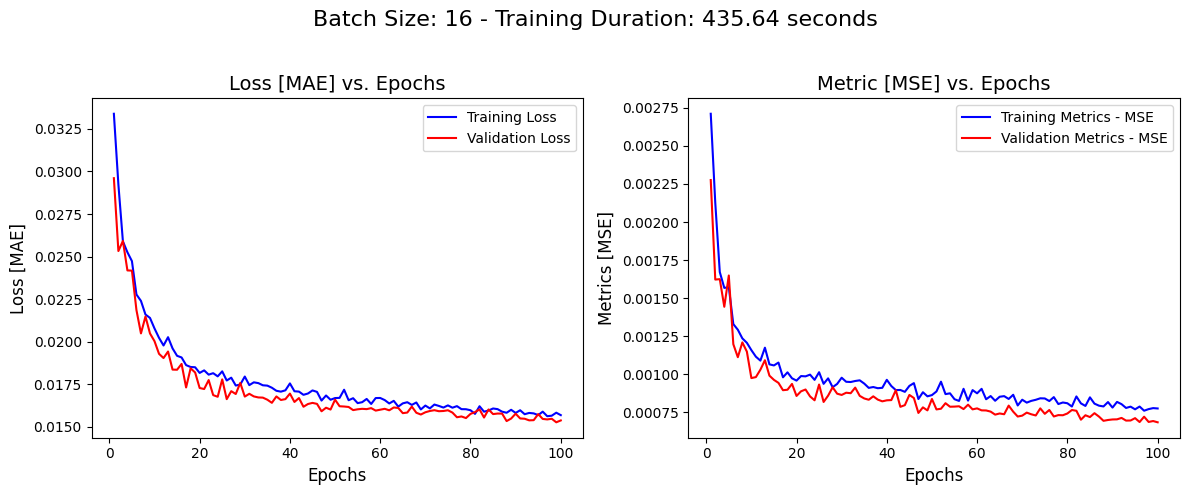

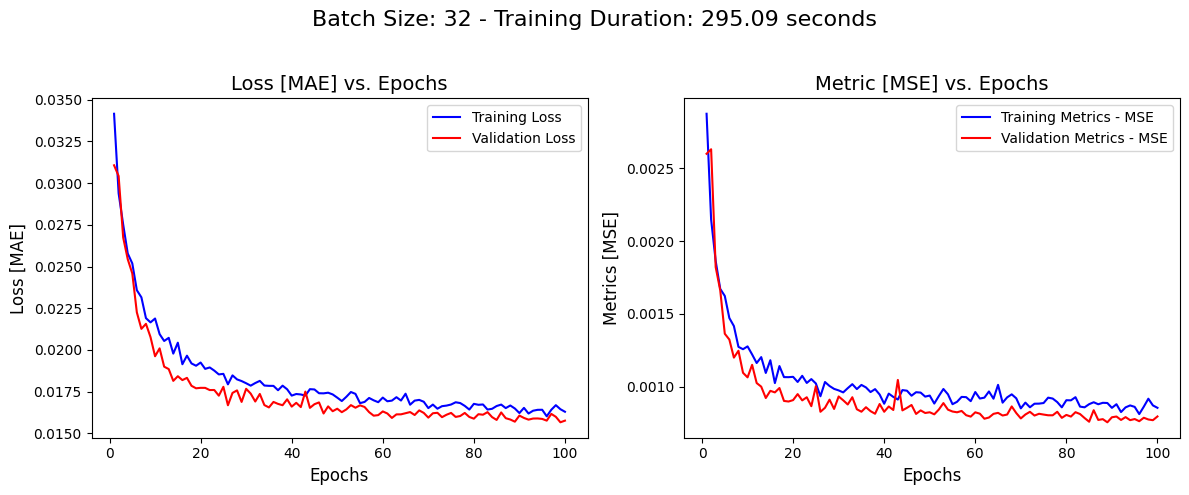

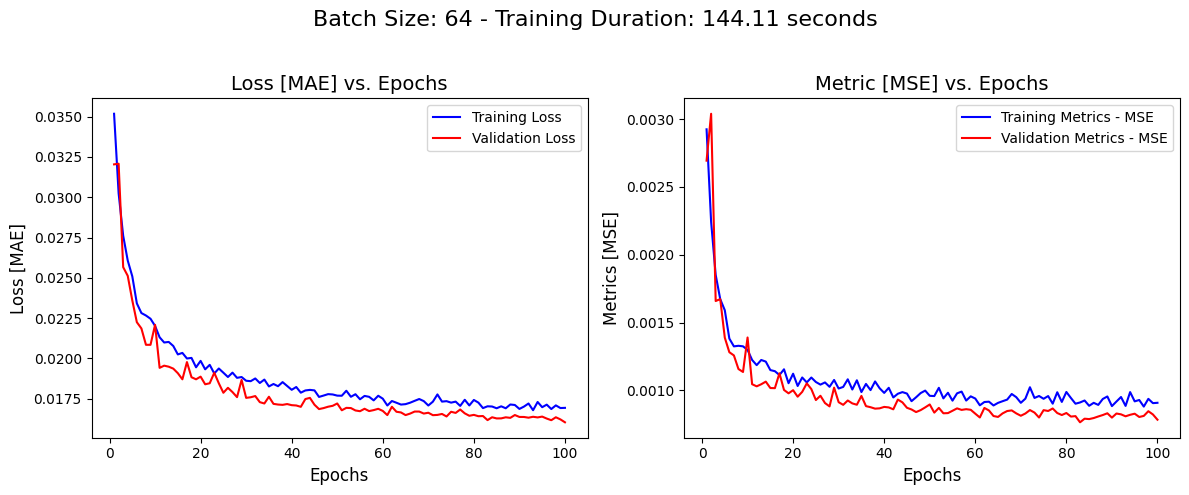

In [ ]:
for batch_size, (history, duration) in history_batch.items():
    # Extract history data
    loss_history = history.history['loss']
    val_loss_history = history.history['val_loss']
    metrics_history = history.history['mean_squared_error']
    val_metrics_history = history.history['val_mean_squared_error']

    epochs_x = np.arange(1, len(loss_history) + 1)  # Epochs for x-axis

    # Figure per Batch Size
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Batch Size: {batch_size} - Training Duration: {duration:.2f} seconds', fontsize=16)

    #  Loss (Training and Validation)
    ax1.plot(epochs_x, loss_history, 'b', label='Training Loss')
    ax1.plot(epochs_x, val_loss_history, 'r', label='Validation Loss')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss [MAE]', fontsize=12)
    ax1.legend(loc='upper right')
    ax1.set_title('Loss [MAE] vs. Epochs', fontsize=14)

    # Mean Squared Error (Training and Validation)
    ax2.plot(epochs_x, metrics_history, 'b', label='Training Metrics - MSE')
    ax2.plot(epochs_x, val_metrics_history, 'r', label='Validation Metrics - MSE')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Metrics [MSE]', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.set_title('Metric [MSE] vs. Epochs', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

**The following figure shows the effect of varying the batch size on training time.**

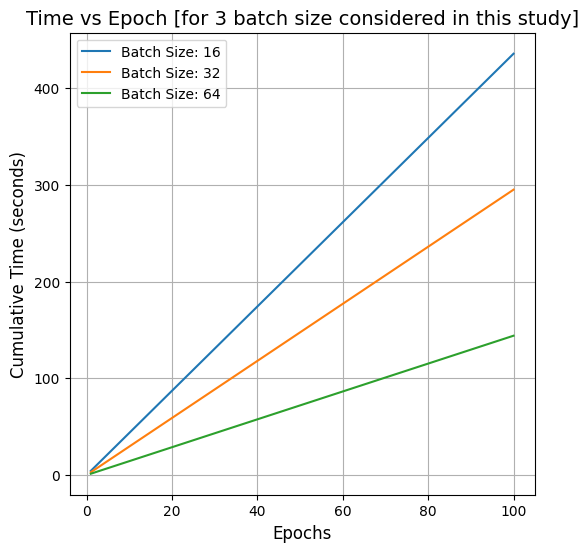

In [ ]:
plt.figure(figsize=(6, 6))
for batch_size, (history, duration) in history_batch.items():
    num_epochs = len(history.history['loss'])
    epochs_x = np.arange(1, num_epochs + 1)
    time_per_epoch = duration / num_epochs
    time_vs_epoch = [time_per_epoch * epoch for epoch in epochs_x]

    ##  line for each batch size
    plt.plot(epochs_x, time_vs_epoch, linestyle='-', label=f'Batch Size: {batch_size}')

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Cumulative Time (seconds)', fontsize=12)
plt.title('Time vs Epoch [for 3 batch size considered in this study]', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Store  metrics for each batch size
results_batch = {}


Evaluating model for batch size: 16
Model saved at: /content/results/model_batch_16.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Model evaluation (loss, MSE) for batch size 16: [0.015653491020202637, 0.0007548812427558005]


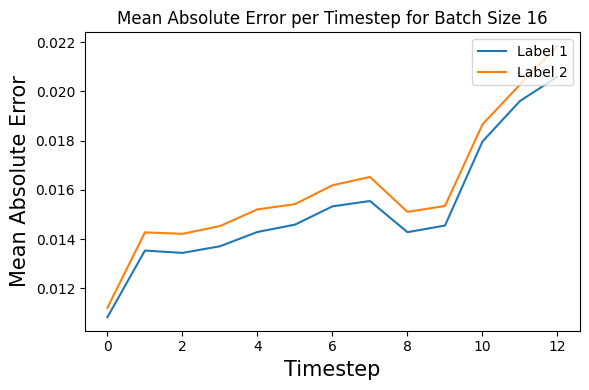


Evaluating model for batch size: 32
Model saved at: /content/results/model_batch_32.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model evaluation (loss, MSE) for batch size 32: [0.015653492882847786, 0.0007548810681328177]


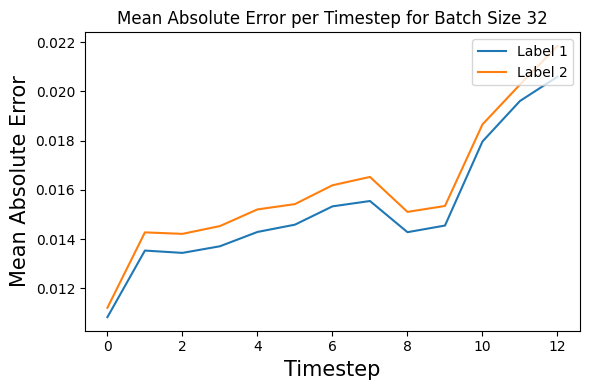


Evaluating model for batch size: 64
Model saved at: /content/results/model_batch_64.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
Model evaluation (loss, MSE) for batch size 64: [0.015653492882847786, 0.0007548810681328177]


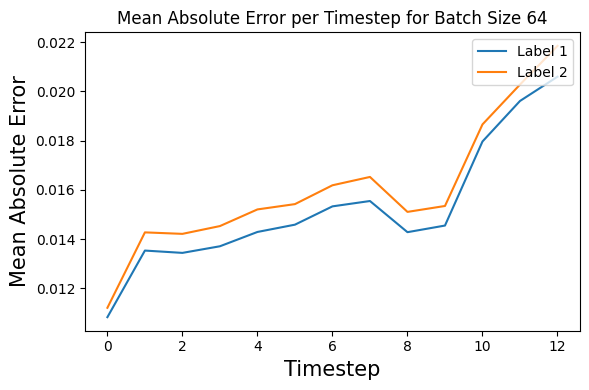

In [ ]:
# Loop through each batch size to save the model
for batch_size, (history, duration) in history_batch.items():
    print(f"\nEvaluating model for batch size: {batch_size}")

    model_save_path = f'/content/results/model_batch_{batch_size}.keras'
    try:
        model.save(model_save_path)
        print(f"Model saved at: {model_save_path}")
    except Exception as e:
        print(f"Failed to save model for batch size {batch_size}: {e}")

    y_test_prediction = model.predict(X_test, batch_size=batch_size) # Predict using the trained model

    # Evaluate model performance on the test set
    model_eval = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    print(f"Model evaluation (loss, MSE) for batch size {batch_size}: {model_eval}")

    # Calculate errors
    errors = np.abs(y_test - y_test_prediction)

    # Compute mean error for two labels
    mean_errors_per_timestep = errors.mean(axis=0)

    # Store results
    results_batch[batch_size] = {
        "model_eval": model_eval,
        "y_test_prediction": y_test_prediction,
        "mean_errors_per_timestep": mean_errors_per_timestep
    }

    # Mean error for each label
    plt.figure(figsize=(6, 4))
    plt.plot(mean_errors_per_timestep[:, 0], label='Label 1')
    plt.plot(mean_errors_per_timestep[:, 1], label='Label 2')
    plt.xlabel('Timestep', fontsize=15)
    plt.ylabel('Mean Absolute Error', fontsize=15)
    plt.legend(loc='upper right')
    plt.title(f"Mean Absolute Error per Timestep for Batch Size {batch_size}")
    plt.tight_layout()
    plt.show()

**The results/errors are shown for the scaled labels in this notebook. We'll perform inverse transform in the next milestone when we consider Feature importance.**

<ipython-input-36-b7b546a840e3>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis", len(percentiles))


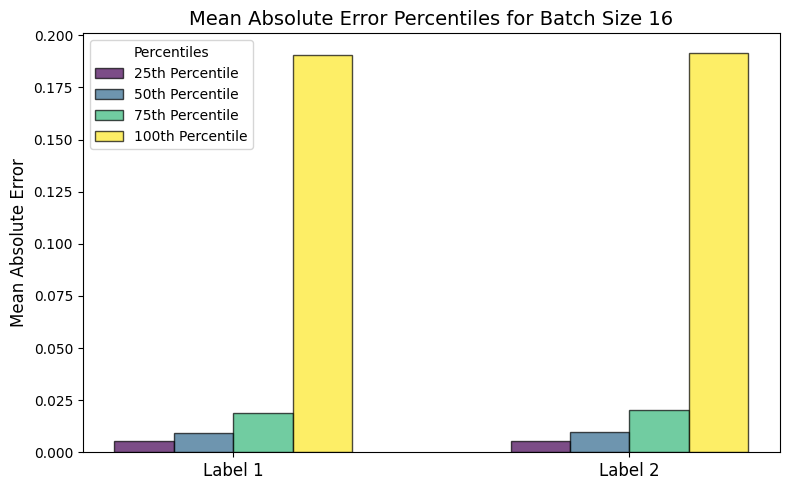

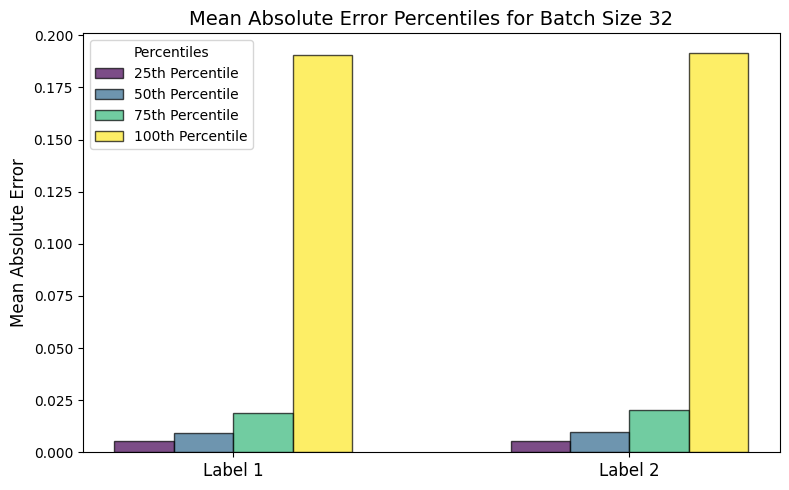

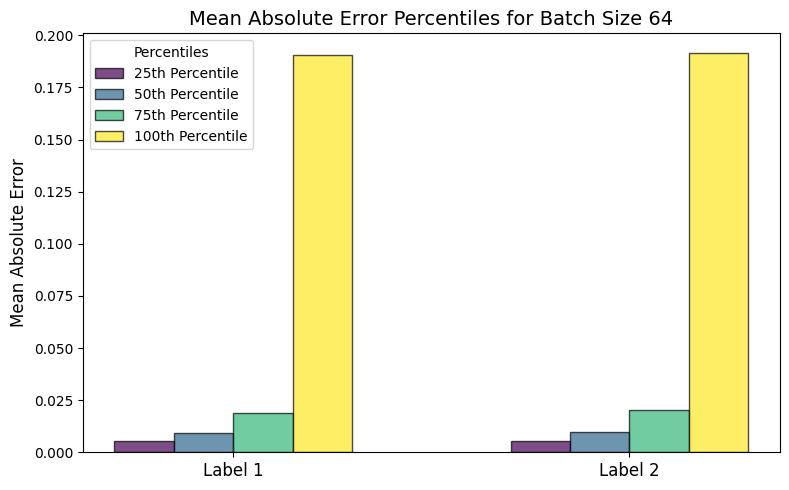

In [ ]:
# Color map
percentiles = [25, 50, 75, 100]
cmap = cm.get_cmap("viridis", len(percentiles))

# Loop through each batch size
for batch_size, results in results_batch.items():
    errors = np.abs(y_test - results["y_test_prediction"])

    # Mean error
    mean_errors_per_sample = errors.mean(axis=1)

    # Compute errors
    percentiles = [25, 50, 75, 100]  # Include 100th percentile for worst-case scenario
    features = ['Label 1', 'Label 2']
    error_percentiles = np.percentile(mean_errors_per_sample, percentiles, axis=0)

    # Plot error percentiles
    plt.figure(figsize=(8, 5))
    bar_width = 0.15
    x = np.arange(len(features))

    # Plot each percentile as a separate set of bars
    for i, perc in enumerate(percentiles):
        color = cmap(i / len(percentiles))  # Gradient color
        plt.bar(x + i * bar_width, error_percentiles[i],
                width=bar_width,
                label=f'{perc}th Percentile',
                color=color,
                edgecolor='black',  # Black edges for each bar
                alpha=0.7)  # Set transparency

    plt.xticks(x + bar_width * 1.5, features, fontsize=12)
    plt.ylabel('Mean Absolute Error', fontsize=12)
    plt.title(f'Mean Absolute Error Percentiles for Batch Size {batch_size}', fontsize=14)
    plt.legend(title='Percentiles', fontsize=10)
    plt.tight_layout()
    plt.show()

# **Step 4: Optimizer Exploration**

In [ ]:
optimizers_list = {
    "Adam": tf.keras.optimizers.Adam,
    "RMSprop": tf.keras.optimizers.RMSprop,
    "SGD": tf.keras.optimizers.SGD,
    "Adagrad": tf.keras.optimizers.Adagrad,
    "Adadelta": tf.keras.optimizers.Adadelta,
    # "Nadam": tf.keras.optimizers.Nadam,
    # "Ftrl": tf.keras.optimizers.Ftrl
}

history_optimizers = {}

# Loop through each optimizer
for opt_name, opt_class in optimizers_list.items():
    print(f"\nTraining optimizer: {opt_name}")

    model = create_model(input_shape, output_shape)
    history, train_duration = train_model(model, X_train, y_train, batch_size=64, optim=opt_class(1e-3))
    history_optimizers[opt_name] = history


Training optimizer: Adam
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 127s 135ms/step - loss: 0.0399 - mean_squared_error: 0.0036 - val_loss: 0.0331 - val_mean_squared_error: 0.0026
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0318 - mean_squared_error: 0.0024 - val_loss: 0.0277 - val_mean_squared_error: 0.0018
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0278 - mean_squared_error: 0.0019 - val_loss: 0.0271 - val_mean_squared_error: 0.0019
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0269 - mean_squared_error: 0.0018 - val_loss: 0.0257 - val_mean_squared_error: 0.0017
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0257 - mean_squared_error: 0.0017 - val_loss: 0.0232 - val_mean_squared_error: 0.0013
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0246 - mean_squared_error: 0.0015 - val_loss: 0.0225 - val_mean_squared_error: 0.0013
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0237 - mean_squared_e

**We considered the performance of 5 commonly used optimizers for the current dataset. The loss evolution for the training and validation dataset has been plotted in the next code cell.**


1.   Adam     - Adaptive Moment Estimation
2.   RMS Prop - Root Mean Square Propagation
3.   SGD      - Stochastic Gradient Descent
4.   Adagrad  - Adaptive Gradient Algorithm
5.   Adadelta - Adaptive Delta





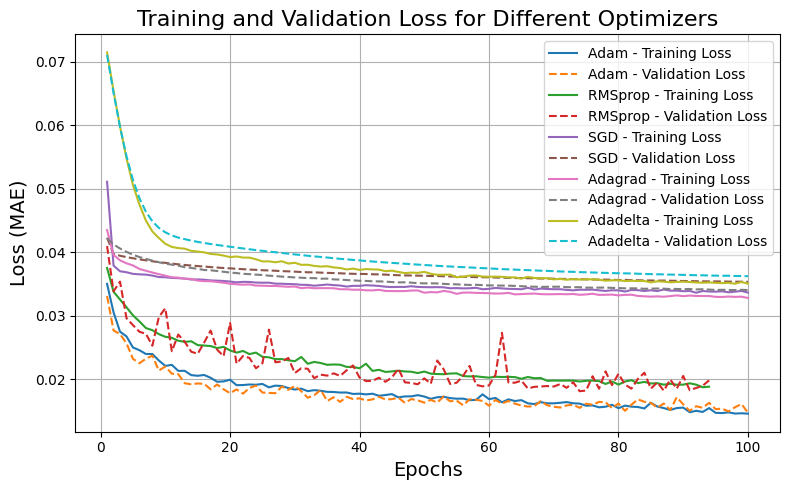

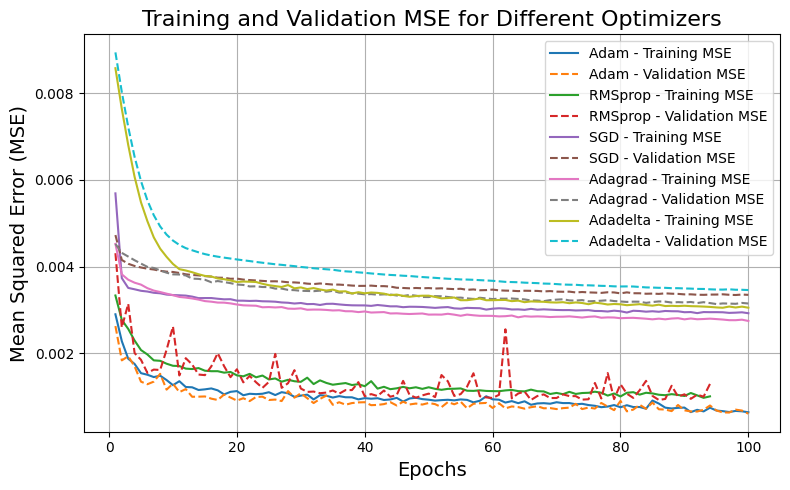

In [ ]:
# epochs_x = np.arange(1, len(next(iter(history_optimizers.values())).history['loss']) + 1)

# Training and Validation Loss for Each Optimizer
plt.figure(figsize=(8, 5))

for opt_name, history in history_optimizers.items():

    epochs_x = np.arange(1, len(history.history['loss']) + 1)
    plt.plot(epochs_x, history.history['loss'], label=f'{opt_name} - Training Loss')
    plt.plot(epochs_x, history.history['val_loss'], linestyle='--', label=f'{opt_name} - Validation Loss')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MAE)', fontsize=14)
plt.title('Training and Validation Loss for Different Optimizers', fontsize=16)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Training and Validation MSE for Each Optimizer
plt.figure(figsize=(8, 5))

for opt_name, history in history_optimizers.items():
    epochs_x = np.arange(1, len(history.history['mean_squared_error']) + 1)
    plt.plot(epochs_x, history.history['mean_squared_error'], label=f'{opt_name} - Training MSE')
    plt.plot(epochs_x, history.history['val_mean_squared_error'], linestyle='--', label=f'{opt_name} - Validation MSE')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('Training and Validation MSE for Different Optimizers', fontsize=16)
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

**Using the plots above, we can observe that the Adam optimizer is able to achieve the lowest error for both the training and validation datasets. While Adadelta performs the worst in terms of loss minimization.**

# **Step 5: Hyperparameter Tuning**

Focus is given to tune the following:

1.   **Learning Rate**
2.   **Batch Size**
3.   **GRU Layers & Unit**


For each hyperparameter, we'll observe validation loss and metrics such as Mean Absolute Error (MAE) and Mean Squared Error (MSE).

## **1. Learning Rate Tuning**

In [ ]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
history_learning_rates = {}

# Loop through each learning rate
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    model = create_model(input_shape, output_shape)
    history, train_duration = train_model(
        model, X_train, y_train, batch_size=64, optim=optimizers.Adam(learning_rate=lr)
    )
    # Store the history for each learning rate
    history_learning_rates[lr] = history


Training with learning rate: 0.01
Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - loss: 0.0970 - mean_squared_error: 0.0791 - val_loss: 0.0366 - val_mean_squared_error: 0.0035
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0340 - mean_squared_error: 0.0029 - val_loss: 0.0342 - val_mean_squared_error: 0.0031
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0331 - mean_squared_error: 0.0028 - val_loss: 0.0341 - val_mean_squared_error: 0.0033
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0318 - mean_squared_error: 0.0026 - val_loss: 0.0313 - val_mean_squared_error: 0.0024
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0314 - mean_squared_error: 0.0024 - val_loss: 0.0319 - val_mean_squared_error: 0.0026
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0307 - mean_squared_error: 0.0023 - val_loss: 0.0299 - val_mean_squared_error: 0.0023
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0284 - mean_s

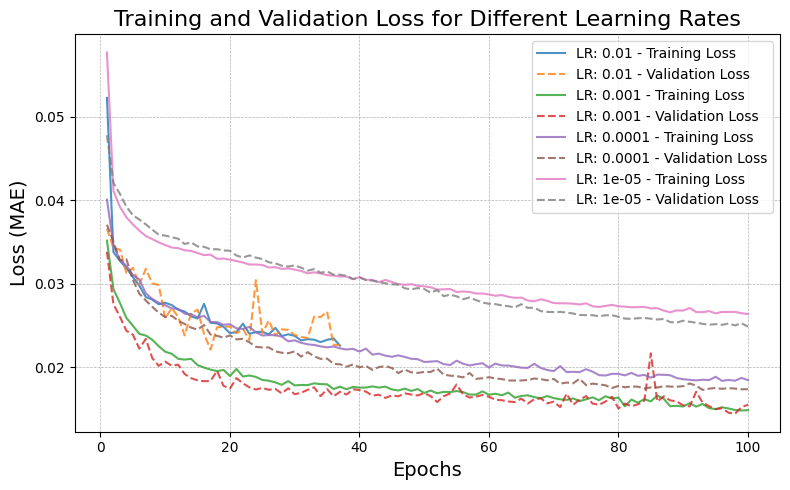

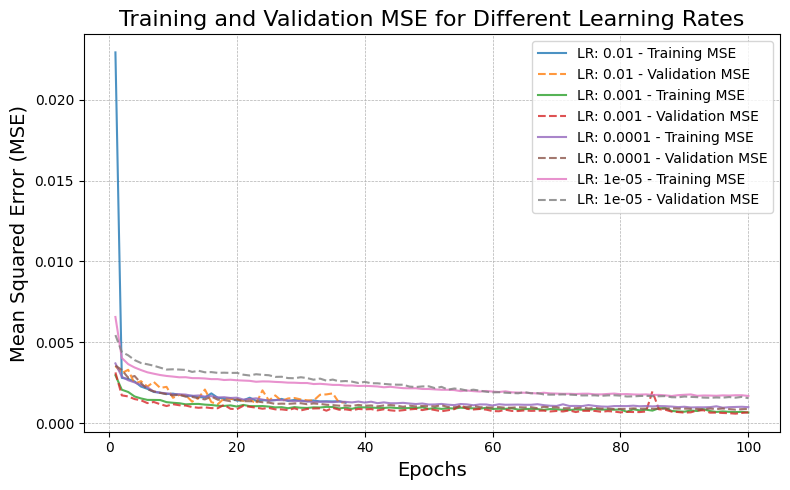

In [ ]:
plt.figure(figsize=(8, 5))

for lr, history in history_learning_rates.items():
    epochs_x = np.arange(1, len(history.history['loss']) + 1)
    plt.plot(epochs_x, history.history['loss'], label=f'LR: {lr} - Training Loss', alpha=0.8)
    plt.plot(epochs_x, history.history['val_loss'], linestyle='--', label=f'LR: {lr} - Validation Loss', alpha=0.8)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MAE)', fontsize=14)
plt.title('Training and Validation Loss for Different Learning Rates', fontsize=16)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot Training and Validation MSE for Each Learning Rate
plt.figure(figsize=(8, 5))

for lr, history in history_learning_rates.items():
    epochs_x = np.arange(1, len(history.history['mean_squared_error']) + 1)
    plt.plot(epochs_x, history.history['mean_squared_error'], label=f'LR: {lr} - Training MSE', alpha=0.8)
    plt.plot(epochs_x, history.history['val_mean_squared_error'], linestyle='--', label=f'LR: {lr} - Validation MSE', alpha=0.8)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('Training and Validation MSE for Different Learning Rates', fontsize=16)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

**We check the loss and metrics for 4 different learning rates (1e-2, 1e-3, 1e-4, and 1e-5)**. The loss for learning rate **1e-3** is found to be the lowest compared to the other larning rates.

**Batch size tuning**
We use optimal learning rate 1e-3 found in the previous exercise. Next we vary batch sizes to find the optimal batch size for larning rate 1e-3

In [ ]:
batch_sizes = [16, 64, 128]
history_batch_sizes = {}

# Loop through each learning rate
for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")

    model = create_model(input_shape, output_shape)
    history, train_duration = train_model(
        model, X_train, y_train, batch_size=batch_size, optim=optimizers.Adam(learning_rate=1e-3)
    )
    # Store the history for each learning rate
    history_batch_sizes[batch_size] = history


Training with batch size: 16
Epoch 1/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - loss: 0.0369 - mean_squared_error: 0.0033 - val_loss: 0.0326 - val_mean_squared_error: 0.0028
Epoch 2/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0298 - mean_squared_error: 0.0022 - val_loss: 0.0270 - val_mean_squared_error: 0.0017
Epoch 3/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0269 - mean_squared_error: 0.0017 - val_loss: 0.0244 - val_mean_squared_error: 0.0015
Epoch 4/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0256 - mean_squared_error: 0.0017 - val_loss: 0.0240 - val_mean_squared_error: 0.0015
Epoch 5/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0239 - mean_squared_error: 0.0014 - val_loss: 0.0274 - val_mean_squared_error: 0.0017
Epoch 6/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0240 - mean_squared_error: 0.0015 - val_loss: 0.0277 - val_mean_squared_error: 0.0025
Epoch 7/100
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0235 

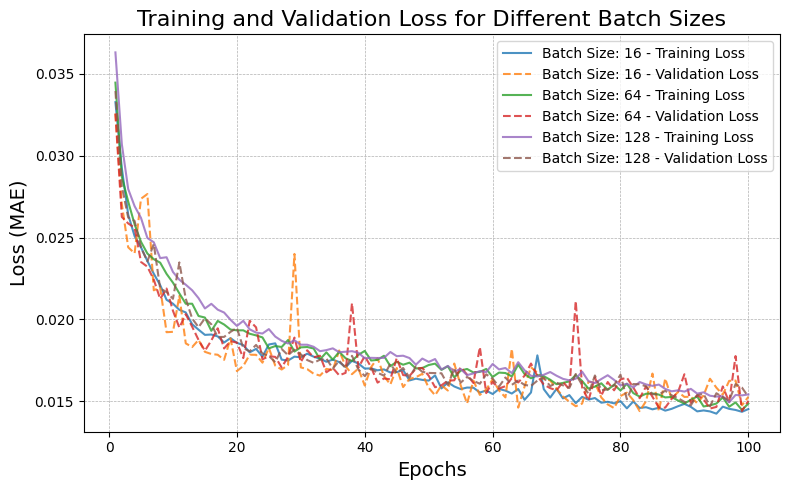

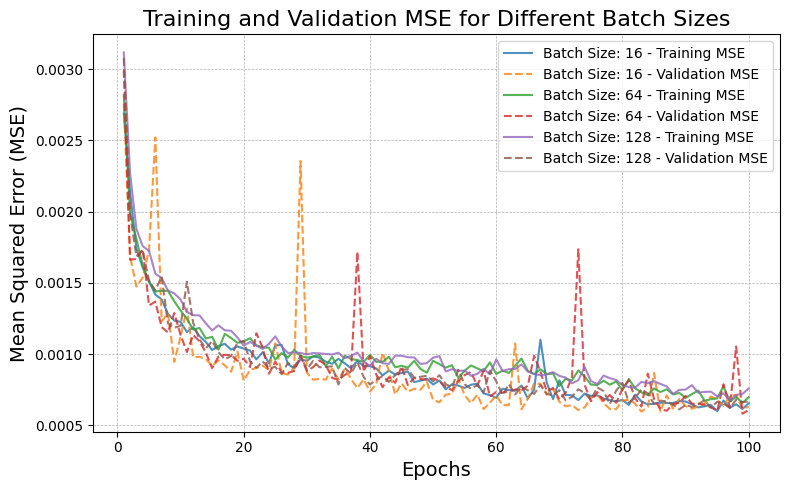

In [ ]:
plt.figure(figsize=(8, 5))

for batch_size, history in history_batch_sizes.items():
    epochs_x = np.arange(1, len(history.history['loss']) + 1)
    plt.plot(epochs_x, history.history['loss'], label=f'Batch Size: {batch_size} - Training Loss', alpha=0.8)
    plt.plot(epochs_x, history.history['val_loss'], linestyle='--', label=f'Batch Size: {batch_size} - Validation Loss', alpha=0.8)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MAE)', fontsize=14)
plt.title('Training and Validation Loss for Different Batch Sizes', fontsize=16)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot Training and Validation MSE for Each Learning Rate
plt.figure(figsize=(8, 5))

for batch_size, history in history_batch_sizes.items():
    epochs_x = np.arange(1, len(history.history['mean_squared_error']) + 1)
    plt.plot(epochs_x, history.history['mean_squared_error'], label=f'Batch Size: {batch_size} - Training MSE', alpha=0.8)
    plt.plot(epochs_x, history.history['val_mean_squared_error'], linestyle='--', label=f'Batch Size: {batch_size} - Validation MSE', alpha=0.8)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('Training and Validation MSE for Different Batch Sizes', fontsize=16)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

**GRU Layers & Unit Tuning**

Experimenting with different layers and units is done to:



*   Optimize model performance: Maximize accuracy or minimize error.
*   Ensure generalization: Prevent underfitting or overfitting.
*   Adapt to the data: Match the model's capacity to the complexity of dataset


Number of layers varied from 2o to 4
Units varied using the following options: 128, 250, 512

In [19]:
# Input Shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
output_shape = y_train.shape[-1]  # Number of output labels per timestep

# Build GRU Model Function
def create_model(input_shape, output_shape, num_layers, units):
    input = layers.Input(shape=input_shape)
    x = input

    for _ in range(num_layers):
        x = layers.GRU(
            units,
            return_sequences=True,
            activation='relu',
            dropout=0.05,
            recurrent_dropout=0.05
        )(x)

    output = layers.TimeDistributed(layers.Dense(output_shape))(x)
    model = Model(inputs=input, outputs=output)
    return model

# Parameter Tuning: GRU Layers and Units
gru_layers = [2, 3, 4]  # Adding more layers for exploration
gru_units = [128, 250, 512]  # GRU units to test
history_gru_params = {}

# Loop through each combination of GRU layers and units
for num_layers in gru_layers:
    for units in gru_units:
        print(f"\nTraining with {num_layers} GRU Layers and {units} Units")

        # Create and compile the model
        model = create_model(input_shape, output_shape, num_layers=num_layers, units=units)
        model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-3),
            loss='mae',
            metrics=['mean_squared_error']
        )

        # Train the model
        history = model.fit(
            X_train, y_train,
            batch_size=128,  # Fixed batch size for this tuning
            epochs=100,  # Fixed number of epochs for tuning
            validation_split=DEFAULT_VALIDATION_SPLIT,
            verbose=1
        )

        # Store history for each parameter combination
        history_gru_params[(num_layers, units)] = history




Training with 2 GRU Layers and 128 Units
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - loss: 0.0420 - mean_squared_error: 0.0038 - val_loss: 0.0337 - val_mean_squared_error: 0.0030
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0326 - mean_squared_error: 0.0026 - val_loss: 0.0321 - val_mean_squared_error: 0.0029
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0310 - mean_squared_error: 0.0024 - val_loss: 0.0307 - val_mean_squared_error: 0.0027
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0307 - mean_squared_error: 0.0024 - val_loss: 0.0280 - val_mean_squared_error: 0.0021
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0279 - mean_squared_error: 0.0018 - val_loss: 0.0263 - val_mean_squared_error: 0.0018
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0269 - mean_squared_error: 0.0018 - val_loss: 0.0262 - val_mean_squared_error: 0.0018
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0260 - mean

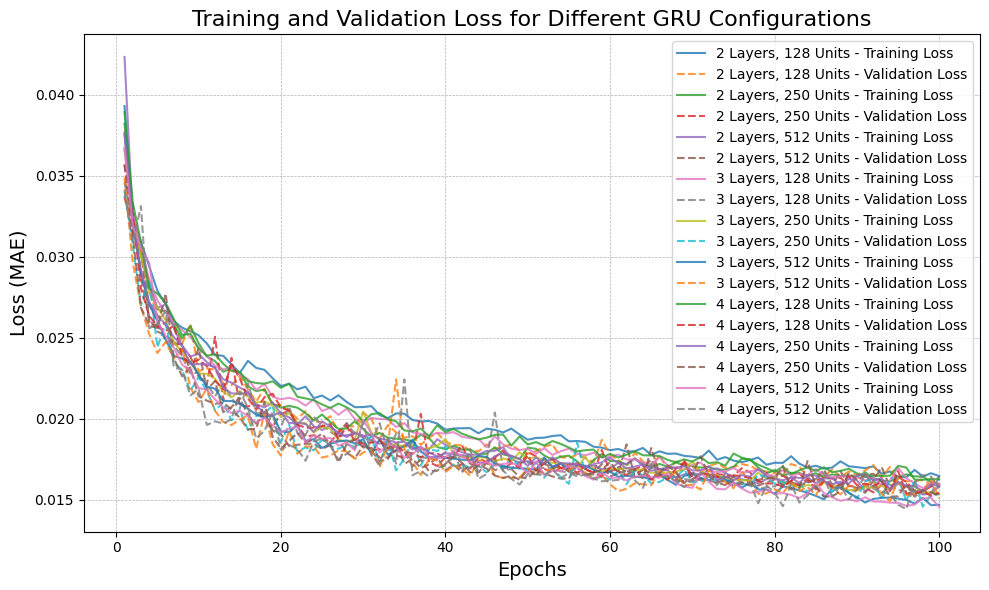

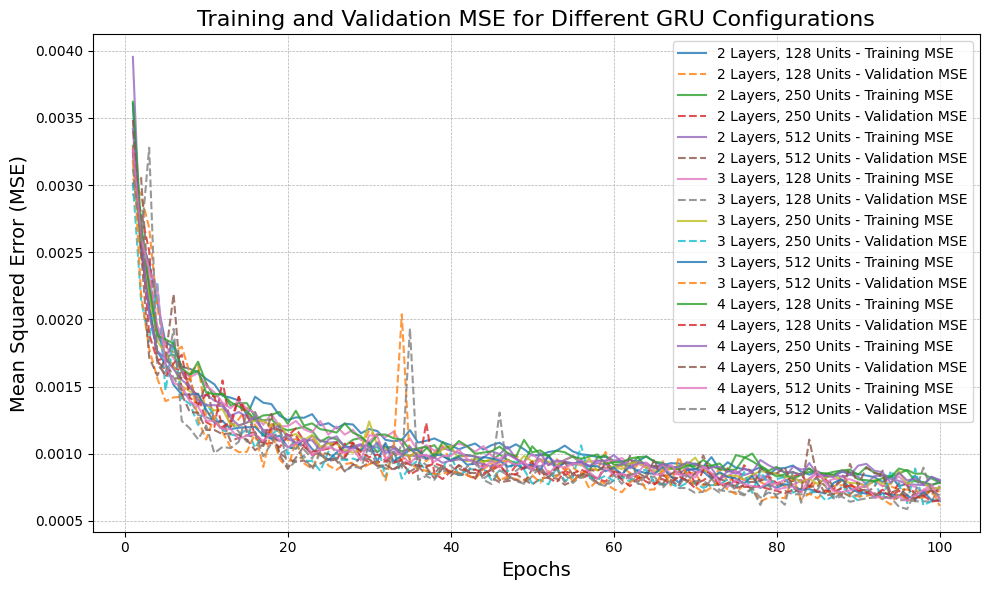

In [21]:
# Plot Results: Training and Validation Loss
plt.figure(figsize=(10, 6))

for (num_layers, units), history in history_gru_params.items():
    epochs_x = np.arange(1, len(history.history['loss']) + 1)
    plt.plot(epochs_x, history.history['loss'], label=f'{num_layers} Layers, {units} Units - Training Loss', alpha=0.8)
    plt.plot(epochs_x, history.history['val_loss'], linestyle='--', label=f'{num_layers} Layers, {units} Units - Validation Loss', alpha=0.8)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (MAE)', fontsize=14)
plt.title('Training and Validation Loss for Different GRU Configurations', fontsize=16)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot Results: Training and Validation MSE
plt.figure(figsize=(10, 6))

for (num_layers, units), history in history_gru_params.items():
    epochs_x = np.arange(1, len(history.history['mean_squared_error']) + 1)
    plt.plot(epochs_x, history.history['mean_squared_error'], label=f'{num_layers} Layers, {units} Units - Training MSE', alpha=0.8)
    plt.plot(epochs_x, history.history['val_mean_squared_error'], linestyle='--', label=f'{num_layers} Layers, {units} Units - Validation MSE', alpha=0.8)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('Training and Validation MSE for Different GRU Configurations', fontsize=16)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [23]:
# Calculate average validation MSE for each configuration
average_mse = {}
for config, history in history_gru_params.items():
    val_mse = history.history['val_mean_squared_error']
    avg_val_mse = np.mean(val_mse)  # Calculate average validation MSE
    average_mse[config] = avg_val_mse

# Create a DataFrame for ranking
ranked_configs = pd.DataFrame([
    {'Configuration': config, 'Average Validation MSE': mse}
    for config, mse in average_mse.items()
])
ranked_configs.sort_values(by='Average Validation MSE', inplace=True)

# Display the ranked configurations
print("\nRanked Configurations by Average Validation MSE:")
print(ranked_configs)

# Identify the best configuration
best_config = ranked_configs.iloc[0]
print(f"\nBest Configuration:\n{best_config.to_dict()}")


Ranked Configurations by Average Validation MSE:
  Configuration  Average Validation MSE
5      (3, 512)                0.000925
8      (4, 512)                0.000953
4      (3, 250)                0.000957
3      (3, 128)                0.000959
2      (2, 512)                0.000964
7      (4, 250)                0.000974
6      (4, 128)                0.000979
1      (2, 250)                0.000996
0      (2, 128)                0.001043

Best Configuration:
{'Configuration': (3, 512), 'Average Validation MSE': 0.000924739433103241}


**Based on the Hyperparameter Tuning, the selected parameters are:**


1.   Learning rate: 1e-03
2.   Batch size: 128
3.   GRU Structure:  3 Layers, 512 Units

